# Stock Price Prediction Using Recurent Neural Networks (RNN) and Long-Short Memory Model(LSTM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense

In [2]:
# Load data
stocks = {
    "AAPL": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\AAPL.csv"),
    "AMZN": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\AMZN.csv"),
    "COKE": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\COKE.csv"),
    "JPM": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\JPM.csv"),
    "MMM": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\MMM.csv"),
    "MSFT": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\MSFT.csv"),
    "PG": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\PG.csv"),
    "WMT": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\WMT.csv")
}

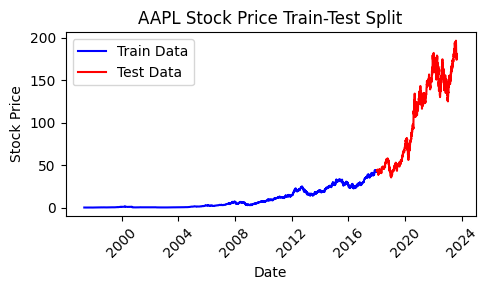

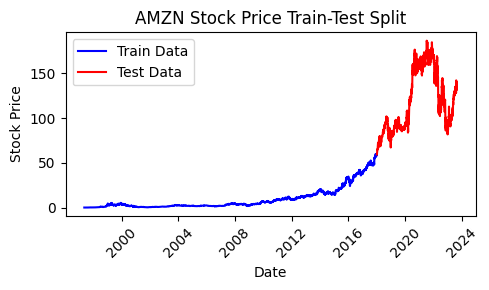

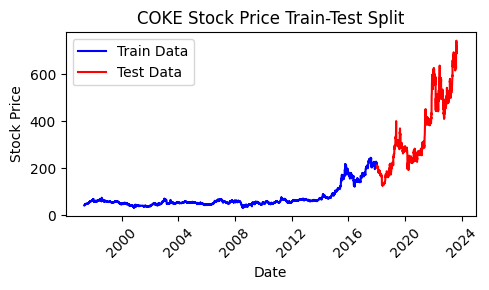

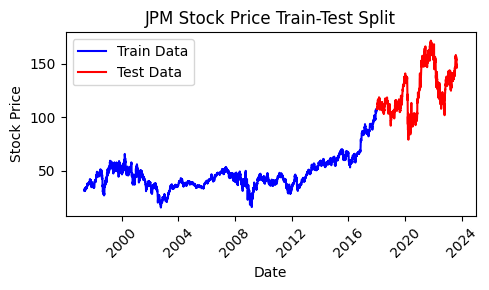

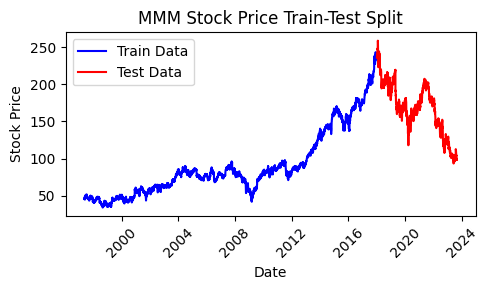

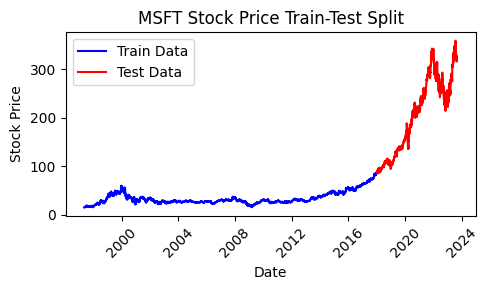

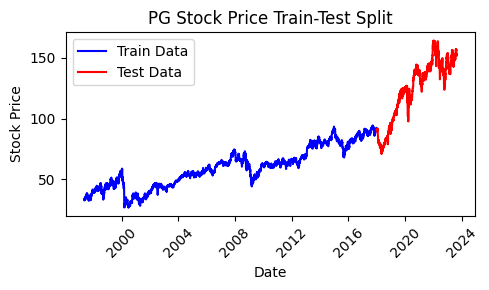

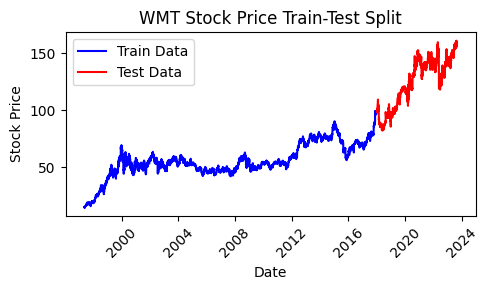

In [3]:
# Plot train and test data splits for each stock
for stock_symbol, stock_data in stocks.items():
    dates = pd.to_datetime(stock_data['Date'])
    prices = stock_data['Close']
    
    # Find the index for the split date
    split_date = pd.to_datetime('2018-01-01')
    split_index = np.where(dates >= split_date)[0][0]

    # Plot train and test data
    plt.figure(figsize=(5, 3))
    plt.plot(dates[:split_index], prices[:split_index], color='blue', label='Train Data')
    plt.plot(dates[split_index:], prices[split_index:], color='red', label='Test Data')
    plt.title(f"{stock_symbol} Stock Price Train-Test Split")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.tight_layout()
    plt.show()

## Getting Data ready for modelling

In [4]:
AAPL = stocks['AAPL']
AMZN = stocks['AMZN']
COKE = stocks['COKE']
JPM = stocks['JPM']
MMM = stocks['MMM']
MSFT = stocks['MSFT']
PG = stocks['PG']
WMT = stocks['WMT']
AAPL.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6608,2023-08-18,172.300003,175.100006,171.960007,174.490005,174.490005,61114200
6609,2023-08-21,175.070007,176.130005,173.740005,175.839996,175.839996,46311900
6610,2023-08-22,177.059998,177.679993,176.250000,177.229996,177.229996,42084200
6611,2023-08-23,178.520004,181.550003,178.330002,181.119995,181.119995,52722800
6612,2023-08-24,180.669998,181.100006,176.009995,176.380005,176.380005,54945800


In [5]:
# Define the prepare_data function
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [6]:
scalers = {}
# Create scalers for each stock symbol and store them in the dictionary
for stock_symbol, stock_data in stocks.items():
    scalers[stock_symbol] = MinMaxScaler()
    scalers[stock_symbol].fit(stock_data['Close'].values.reshape(-1, 1))


In [7]:
# Define the number of time steps for the LSTM
time_steps = 60

# Define a dictionary to store the prepared data for each stock
prepared_data = {}

# Loop through each stock and prepare data
for stock_symbol, stock_data in stocks.items():
    split_date = pd.to_datetime('2018-01-01')  # Convert split_date to Timestamp
    
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])  # Convert 'Date' column to DatetimeIndex
    stock_data.set_index('Date', inplace=True)  # Set 'Date' as index
    
    train_data = stock_data[stock_data.index < split_date]
    test_data = stock_data[stock_data.index >= split_date]

    train_prices = train_data['Close'].values.reshape(-1, 1)
    train_scaled = scalers[stock_symbol].transform(train_prices)
    xtrain, ytrain = prepare_data(train_scaled, time_steps)

    test_prices = test_data['Close'].values.reshape(-1, 1)
    test_scaled = scalers[stock_symbol].transform(test_prices)
    xtest, ytest = prepare_data(test_scaled, time_steps)

    prepared_data[stock_symbol] = {
        'xtrain': xtrain,
        'ytrain': ytrain,
        'xtest': xtest,
        'ytest': ytest
    }

## Long Short Term Memory (LSTM) Model for Price Prediction

In [8]:
# Define a dictionary to store the trained models
trained_models = {}

# Loop through each stock and create and train the LSTM model
for stock_symbol in stocks.keys():
    model = Sequential([
        LSTM(50, input_shape=(time_steps, 1), return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(stock_symbol)
    model.fit(prepared_data[stock_symbol]['xtrain'], prepared_data[stock_symbol]['ytrain'], epochs=5, batch_size=32, validation_split=0.2)
    trained_models[stock_symbol] = model

AAPL
Epoch 1/5
129/129 [==============================] - 8s 37ms/step - loss: 7.4673e-05 - val_loss: 2.3108e-05
Epoch 2/5
129/129 [==============================] - 4s 28ms/step - loss: 3.8133e-06 - val_loss: 2.1683e-05
Epoch 3/5
129/129 [==============================] - 4s 28ms/step - loss: 4.3530e-06 - val_loss: 4.9418e-05
Epoch 4/5
129/129 [==============================] - 4s 29ms/step - loss: 3.5809e-06 - val_loss: 1.9886e-05
Epoch 5/5
129/129 [==============================] - 4s 28ms/step - loss: 3.5928e-06 - val_loss: 1.7758e-05
AMZN
Epoch 1/5
129/129 [==============================] - 8s 34ms/step - loss: 6.0182e-05 - val_loss: 4.4590e-05
Epoch 2/5
129/129 [==============================] - 4s 28ms/step - loss: 3.2256e-06 - val_loss: 9.3288e-05
Epoch 3/5
129/129 [==============================] - 4s 28ms/step - loss: 3.3798e-06 - val_loss: 4.0261e-05
Epoch 4/5
129/129 [==============================] - 4s 29ms/step - loss: 3.0585e-06 - val_loss: 4.2155e-05
Epoch 5/5
129/129 

43/43 [==============================] - 1s 9ms/step


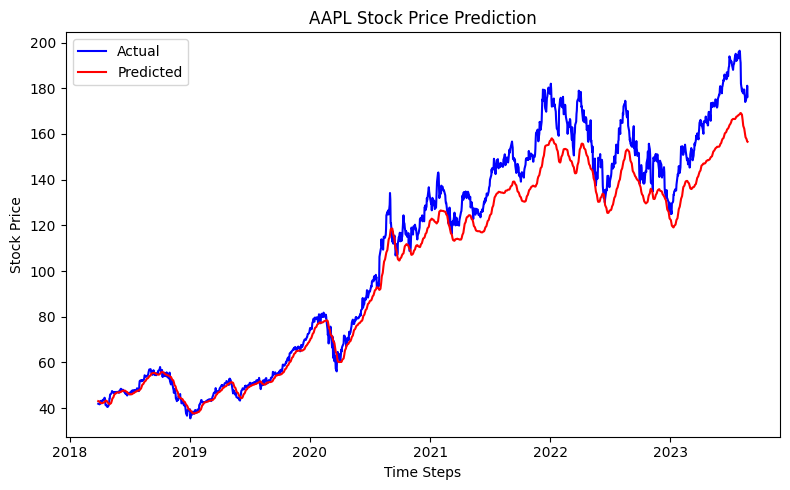

AAPL Stock Price Prediction Evaluation:
MSE: 131.7991
RMSE: 11.4804
MAE: 8.6474
MPAE: 6.59%
43/43 [==============================] - 1s 9ms/step


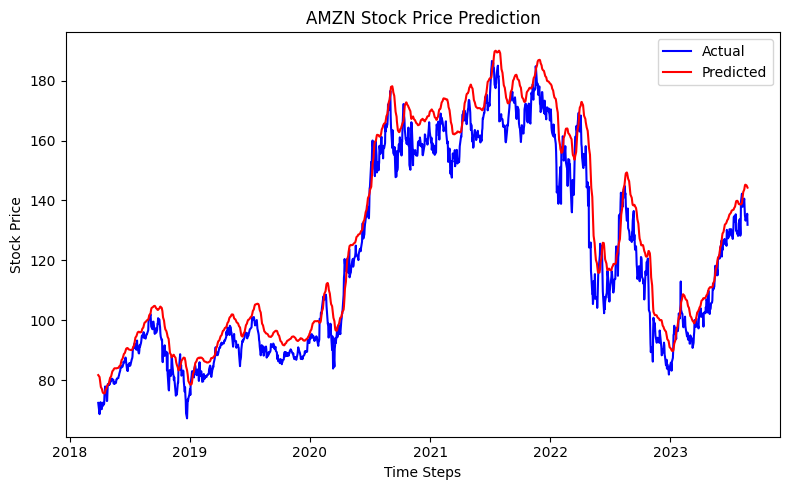

AMZN Stock Price Prediction Evaluation:
MSE: 78.9981
RMSE: 8.8881
MAE: 7.1511
MPAE: 6.07%
43/43 [==============================] - 1s 9ms/step


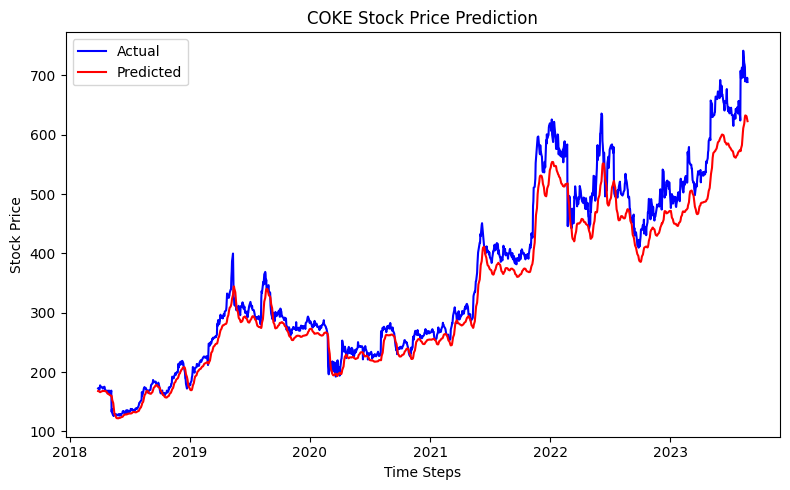

COKE Stock Price Prediction Evaluation:
MSE: 1375.4557
RMSE: 37.0871
MAE: 27.8396
MPAE: 6.92%
43/43 [==============================] - 1s 9ms/step


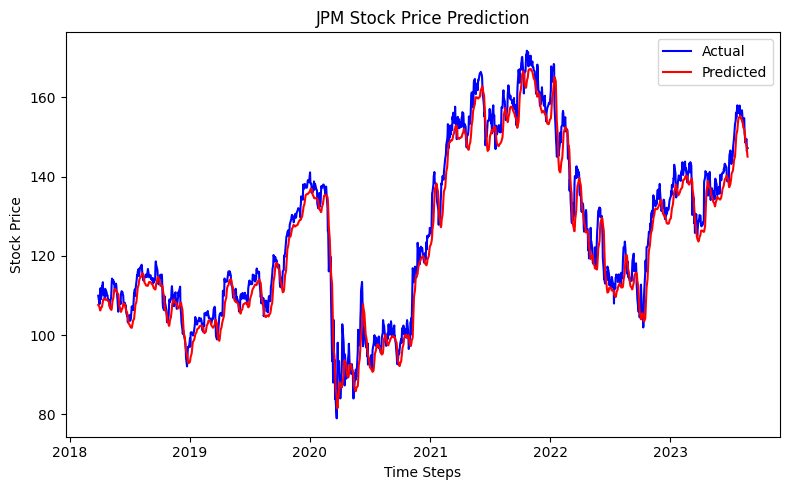

JPM Stock Price Prediction Evaluation:
MSE: 18.4320
RMSE: 4.2932
MAE: 3.4150
MPAE: 2.75%
43/43 [==============================] - 1s 10ms/step


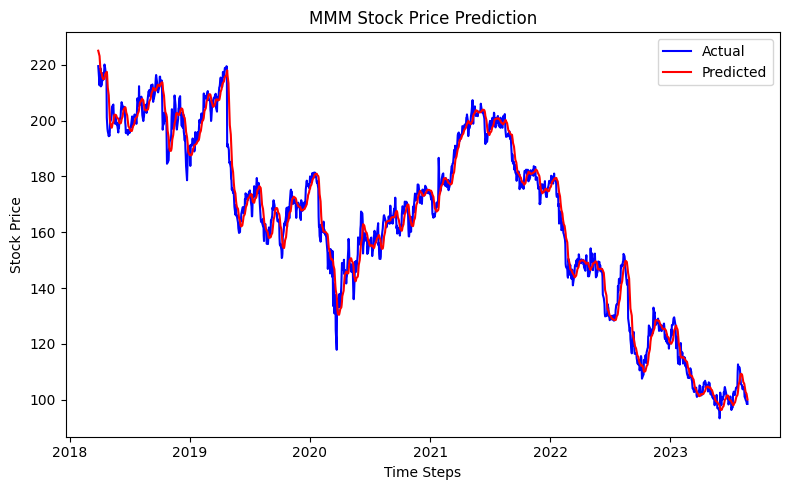

MMM Stock Price Prediction Evaluation:
MSE: 24.1446
RMSE: 4.9137
MAE: 3.5966
MPAE: 2.27%
43/43 [==============================] - 1s 9ms/step


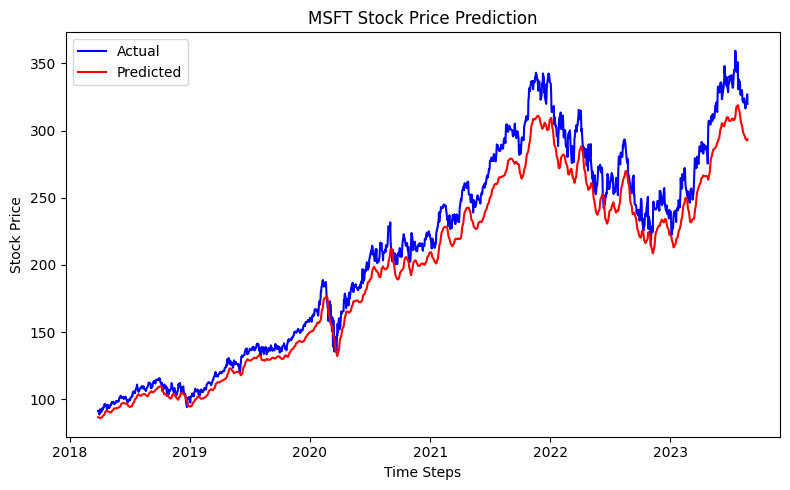

MSFT Stock Price Prediction Evaluation:
MSE: 307.0724
RMSE: 17.5235
MAE: 14.8318
MPAE: 6.61%
43/43 [==============================] - 1s 9ms/step


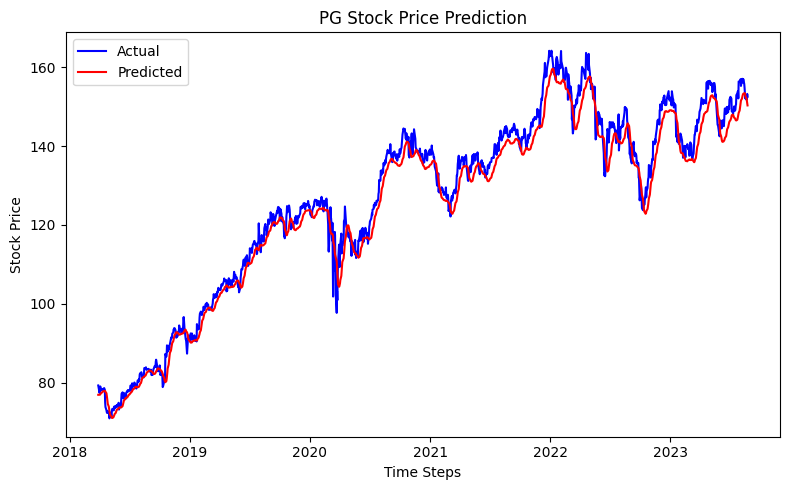

PG Stock Price Prediction Evaluation:
MSE: 12.9585
RMSE: 3.5998
MAE: 2.9297
MPAE: 2.27%
43/43 [==============================] - 1s 10ms/step


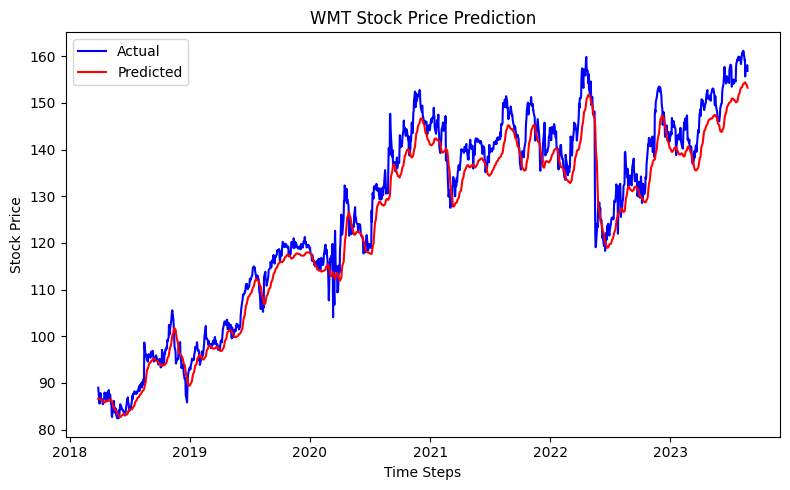

WMT Stock Price Prediction Evaluation:
MSE: 21.6005
RMSE: 4.6476
MAE: 3.6197
MPAE: 2.77%


In [9]:
test_dates = stocks['AAPL'].index.values[-len(prepared_data['AAPL']['ytest']):]

# Loop through each trained model and make predictions
for stock_symbol, model in trained_models.items():
    predictions = model.predict(prepared_data[stock_symbol]['xtest'])
    predictions_actual = scalers[stock_symbol].inverse_transform(predictions)
    ytest_actual = scalers[stock_symbol].inverse_transform(prepared_data[stock_symbol]['ytest'])
    
    
    # Plot the actual test data and predicted results
    plt.figure(figsize=(8, 5))  # Adjust the figure size for better visibility
    plt.plot(test_dates, ytest_actual, label='Actual', color='blue')
    plt.plot(test_dates, predictions_actual, label='Predicted', color='red')
    plt.title(f'{stock_symbol} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Model Evaluation
    mse = mean_squared_error(ytest_actual, predictions_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ytest_actual, predictions_actual)
    mpae = np.mean(np.abs((ytest_actual - predictions_actual) / ytest_actual)) * 100

    print(f"{stock_symbol} Stock Price Prediction Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MPAE: {mpae:.2f}%")


## Recurrent Neural Network (RNN) For Stock Prediction


In [10]:
# Define a dictionary to store the trained models
rnn_models = {}

# Loop through each stock and create and train the LSTM model
for stock_symbol in stocks.keys():
    model = Sequential([
        SimpleRNN(50, input_shape=(time_steps,1), return_sequences=True),
        SimpleRNN(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(stock_symbol)
    model.fit(prepared_data[stock_symbol]['xtrain'], prepared_data[stock_symbol]['ytrain'], epochs=5, batch_size=32, validation_split=0.2)
    rnn_models[stock_symbol] = model

AAPL
Epoch 1/5
129/129 [==============================] - 3s 15ms/step - loss: 0.0058 - val_loss: 4.7755e-04
Epoch 2/5
129/129 [==============================] - 2s 13ms/step - loss: 1.9052e-05 - val_loss: 2.8307e-04
Epoch 3/5
129/129 [==============================] - 2s 13ms/step - loss: 1.3952e-05 - val_loss: 3.8152e-04
Epoch 4/5
129/129 [==============================] - 2s 14ms/step - loss: 1.1195e-05 - val_loss: 3.2462e-04
Epoch 5/5
129/129 [==============================] - 2s 14ms/step - loss: 9.6643e-06 - val_loss: 2.6113e-04
AMZN
Epoch 1/5
129/129 [==============================] - 4s 16ms/step - loss: 0.0014 - val_loss: 1.5063e-04
Epoch 2/5
129/129 [==============================] - 2s 14ms/step - loss: 7.4624e-06 - val_loss: 1.2494e-04
Epoch 3/5
129/129 [==============================] - 2s 13ms/step - loss: 7.2823e-06 - val_loss: 1.4260e-04
Epoch 4/5
129/129 [==============================] - 2s 13ms/step - loss: 6.2910e-06 - val_loss: 1.3473e-04
Epoch 5/5
129/129 [=======

43/43 [==============================] - 0s 4ms/step


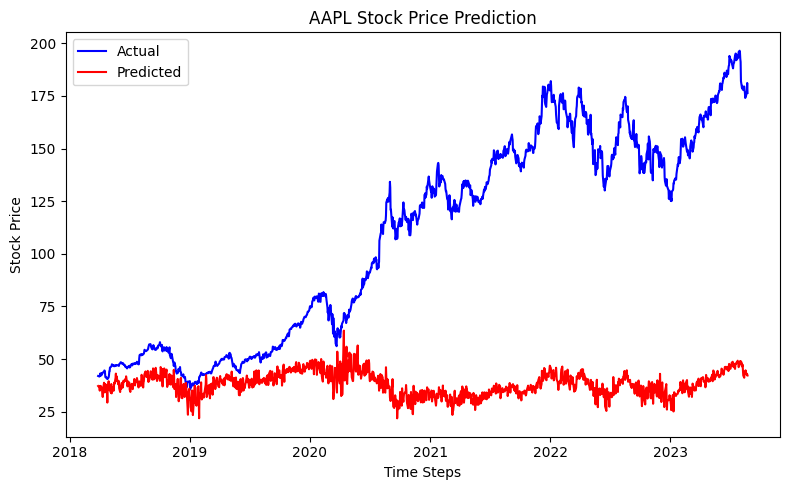

AAPL Stock Price Prediction Evaluation:
MSE: 7408.5912
RMSE: 86.0732
MAE: 70.6239
MPAE: 54.39%
43/43 [==============================] - 0s 4ms/step


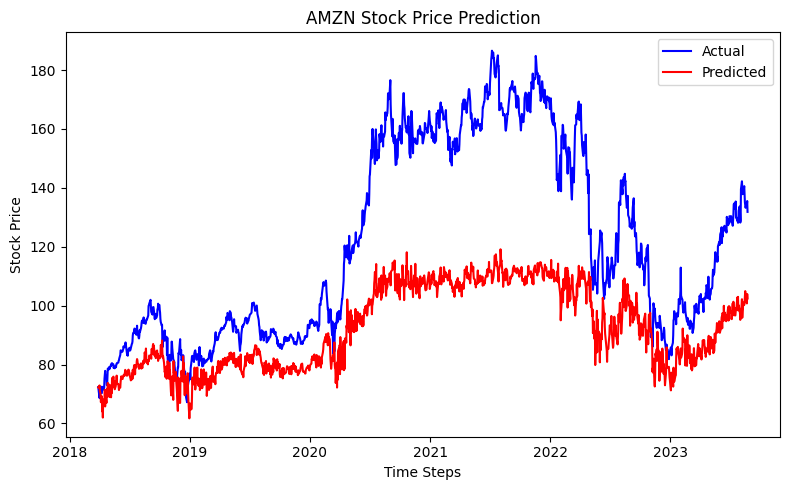

AMZN Stock Price Prediction Evaluation:
MSE: 1229.1122
RMSE: 35.0587
MAE: 28.7902
MPAE: 21.14%
43/43 [==============================] - 0s 4ms/step


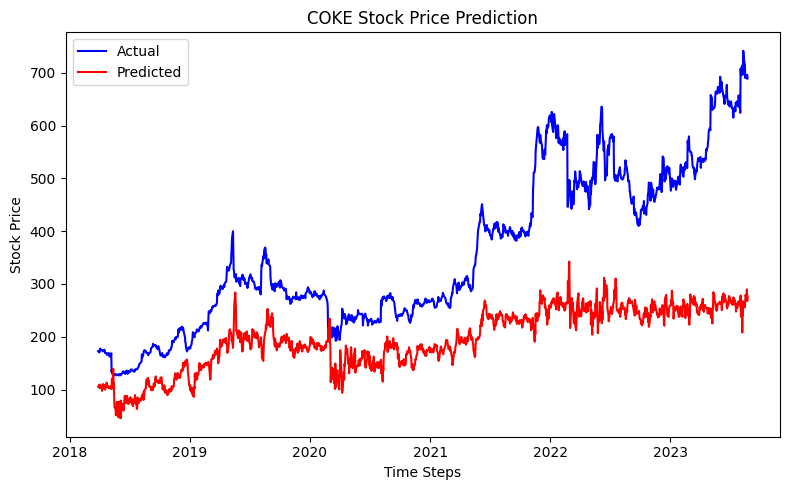

COKE Stock Price Prediction Evaluation:
MSE: 36214.6253
RMSE: 190.3014
MAE: 160.8286
MPAE: 42.11%
43/43 [==============================] - 0s 4ms/step


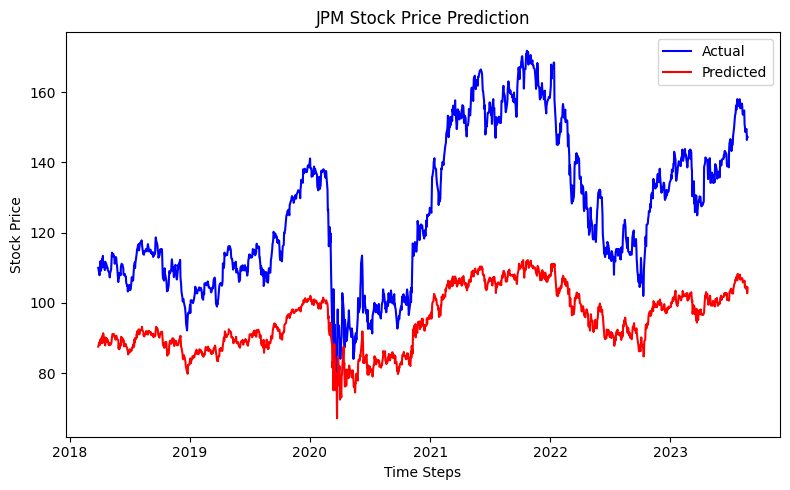

JPM Stock Price Prediction Evaluation:
MSE: 1093.4039
RMSE: 33.0667
MAE: 30.4621
MPAE: 23.26%
43/43 [==============================] - 0s 4ms/step


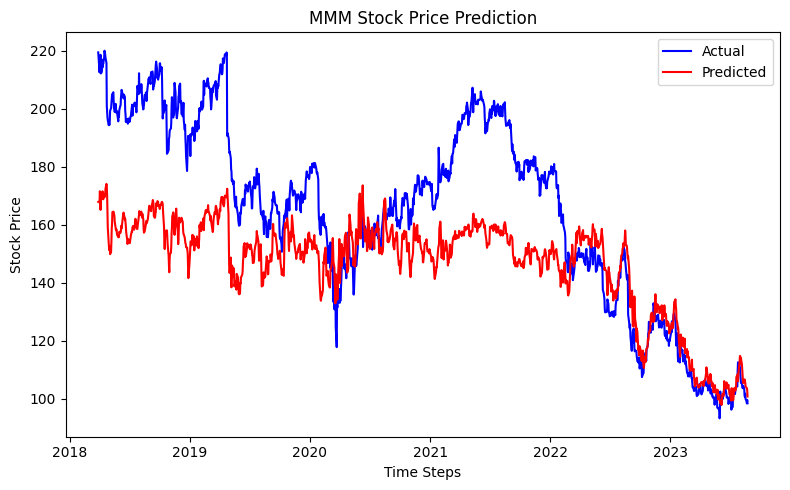

MMM Stock Price Prediction Evaluation:
MSE: 703.2476
RMSE: 26.5188
MAE: 21.3036
MPAE: 11.70%
43/43 [==============================] - 0s 4ms/step


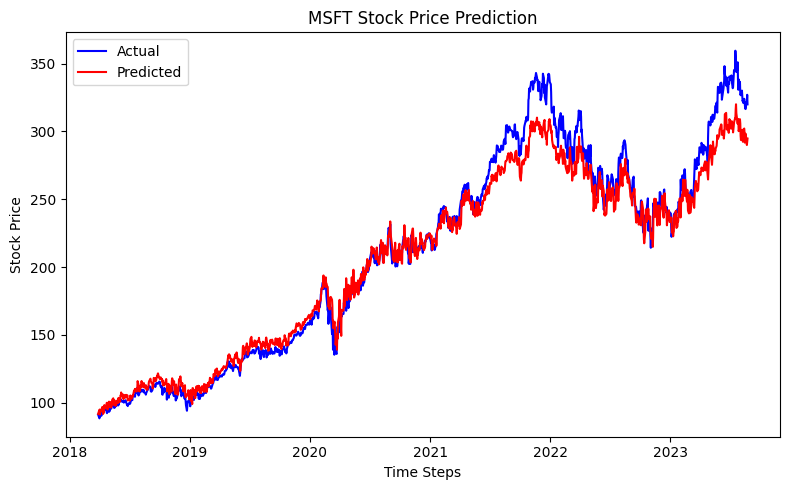

MSFT Stock Price Prediction Evaluation:
MSE: 186.5344
RMSE: 13.6578
MAE: 9.9537
MPAE: 4.36%
43/43 [==============================] - 0s 4ms/step


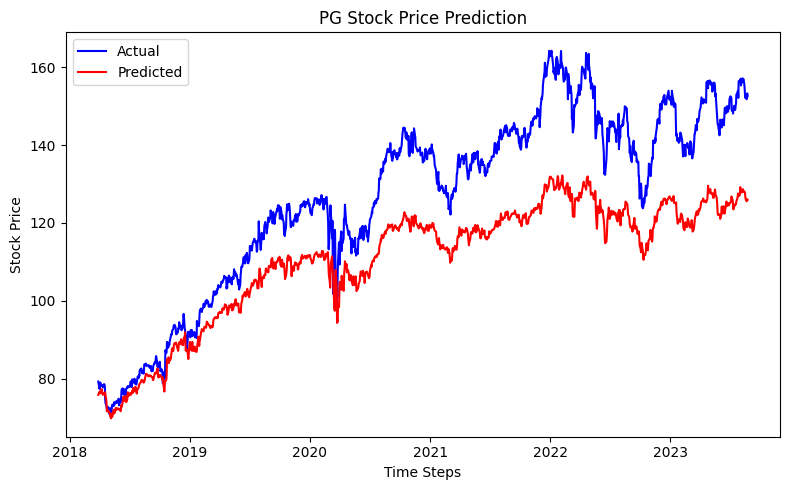

PG Stock Price Prediction Evaluation:
MSE: 319.0483
RMSE: 17.8619
MAE: 15.7853
MPAE: 11.59%
43/43 [==============================] - 0s 4ms/step


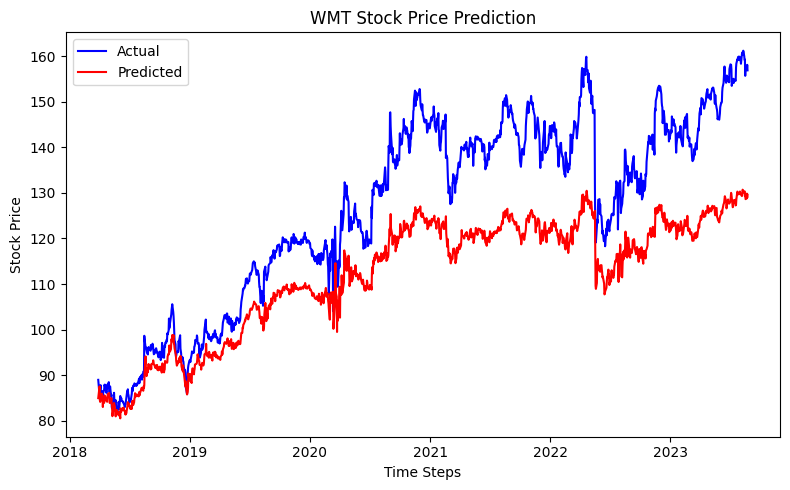

WMT Stock Price Prediction Evaluation:
MSE: 275.1405
RMSE: 16.5874
MAE: 14.5125
MPAE: 10.68%


In [11]:
test_dates = stocks['AAPL'].index.values[-len(prepared_data['AAPL']['ytest']):]

# Loop through each trained model and make predictions
for stock_symbol, model in rnn_models.items():
    predictions = model.predict(prepared_data[stock_symbol]['xtest'])
    predictions_actual = scalers[stock_symbol].inverse_transform(predictions)
    ytest_actual = scalers[stock_symbol].inverse_transform(prepared_data[stock_symbol]['ytest'])
    
    
    # Plot the actual test data and predicted results
    plt.figure(figsize=(8, 5))  # Adjust the figure size for better visibility
    plt.plot(test_dates, ytest_actual, label='Actual', color='blue')
    plt.plot(test_dates, predictions_actual, label='Predicted', color='red')
    plt.title(f'{stock_symbol} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Model Evaluation
    mse = mean_squared_error(ytest_actual, predictions_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ytest_actual, predictions_actual)
    mpae = np.mean(np.abs((ytest_actual - predictions_actual) / ytest_actual)) * 100

    print(f"{stock_symbol} Stock Price Prediction Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MPAE: {mpae:.2f}%")

## Autoregressive Integrated Moving Average (ARIMA) For Stock Prediction

In [79]:
# Define a function to fit and forecast with ARIMA
def arima_forecast(data, order):
    model = ARIMA(data, order=order)
    results = model.fit()
    forecast = results.predict(start=len(data), end=len(data) + len(prepared_data[stock_symbol]['ytest']) - 1, typ='levels')
    return forecast

In [80]:
# Define the ARIMA order (p, d, q)
arima_order = (2, 1, 2)  # Example values

# Loop through each stock and create and fit the ARIMA model
for stock_symbol in stocks.keys():
    ytrain_actual = scalers[stock_symbol].inverse_transform(prepared_data[stock_symbol]['ytrain'])

    # Fit ARIMA model
    arima_predictions = arima_forecast(ytrain_actual, order=arima_order)
    arima_predictions_actual = scalers[stock_symbol].inverse_transform(arima_predictions)
    ytest_actual = scalers[stock_symbol].inverse_transform(prepared_data[stock_symbol]['ytest'])
    
    # Plot the actual test data and ARIMA predicted results
    plt.figure(figsize=(8, 5))
    plt.plot(test_dates, ytest_actual, label='Actual', color='blue')
    plt.plot(test_dates, arima_predictions_actual, label='ARIMA Predicted', color='green')
    plt.title(f'{stock_symbol} Stock Price Prediction (ARIMA)')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Model Evaluation
    mse = mean_squared_error(ytest_actual, arima_predictions_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ytest_actual, arima_predictions_actual)
    mpae = np.mean(np.abs((ytest_actual - arima_predictions_actual) / ytest_actual)) * 100

    print(f"{stock_symbol} Stock Price ARIMA Prediction Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MPAE: {mpae:.2f}%")


c:\Users\Ethan Scott\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[42.34195889 42.3448962  42.31287178 ... 42.32043662 42.32043662
 42.32043662].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.